### Лабораторна робота 1
### «Побудова моделі регресії»
### дисципліна: «Побудова моделей машинного навчання»
### Виконала: студентка групи КС42 Гребенюк Єлизавета Миколаївна
### Варіант 5

#### Аналіз та побудова моделі регресії для прогнозування ціни автомобіля
#### Датасет: [Car Price](https://www.kaggle.com/datasets/hellbuoy/car-price-prediction)

##### 0. Імпорт бібліотек

In [4]:
# Working with files and data manipulation
import os
import numpy as np  # Linear algebra
import pandas as pd  # Data handling

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt
# Display plots inside the notebook
%matplotlib inline

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Machine Learning utilities
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# Regression models
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn import tree

##### 1. Завантаження датасету

In [39]:
df = pd.read_csv('./CarPrice_Assignment.csv')
# Display the first 5 rows of the dataset
df.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


##### 2. Препроцесінг даних

In [40]:
# Display all column names
df.columns

Index(['car_ID', 'symboling', 'CarName', 'fueltype', 'aspiration',
       'doornumber', 'carbody', 'drivewheel', 'enginelocation', 'wheelbase',
       'carlength', 'carwidth', 'carheight', 'curbweight', 'enginetype',
       'cylindernumber', 'enginesize', 'fuelsystem', 'boreratio', 'stroke',
       'compressionratio', 'horsepower', 'peakrpm', 'citympg', 'highwaympg',
       'price'],
      dtype='object')

In [41]:
# Select relevant features for car price prediction
selected_columns = [
    'CarName', 'fueltype', 'aspiration', 'doornumber', 'carbody',
    'drivewheel', 'enginelocation', 'wheelbase', 'carlength', 'carwidth',
    'carheight', 'curbweight', 'enginetype', 'cylindernumber', 'enginesize',
    'fuelsystem', 'boreratio', 'stroke', 'compressionratio', 'horsepower',
    'peakrpm', 'citympg', 'highwaympg', 'price'
]

df_train = df[selected_columns]

In [42]:
# Check for null values
print(df_train.isnull().sum())

CarName             0
fueltype            0
aspiration          0
doornumber          0
carbody             0
drivewheel          0
enginelocation      0
wheelbase           0
carlength           0
carwidth            0
carheight           0
curbweight          0
enginetype          0
cylindernumber      0
enginesize          0
fuelsystem          0
boreratio           0
stroke              0
compressionratio    0
horsepower          0
peakrpm             0
citympg             0
highwaympg          0
price               0
dtype: int64


In [43]:
# Check for duplicated rows
df_train.duplicated().sum()

np.int64(0)

In [44]:
# Check basic info about the dataset
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CarName           205 non-null    object 
 1   fueltype          205 non-null    object 
 2   aspiration        205 non-null    object 
 3   doornumber        205 non-null    object 
 4   carbody           205 non-null    object 
 5   drivewheel        205 non-null    object 
 6   enginelocation    205 non-null    object 
 7   wheelbase         205 non-null    float64
 8   carlength         205 non-null    float64
 9   carwidth          205 non-null    float64
 10  carheight         205 non-null    float64
 11  curbweight        205 non-null    int64  
 12  enginetype        205 non-null    object 
 13  cylindernumber    205 non-null    object 
 14  enginesize        205 non-null    int64  
 15  fuelsystem        205 non-null    object 
 16  boreratio         205 non-null    float64
 1

In [45]:
# Identify categorical and numerical columns
cat_val = df_train.select_dtypes(include=['object']).columns
num_val = df_train.select_dtypes(include=['int', 'float']).columns

print("Categorical Features:\n", cat_val)
print("\nNumerical Features:\n", num_val)

Categorical Features:
 Index(['CarName', 'fueltype', 'aspiration', 'doornumber', 'carbody',
       'drivewheel', 'enginelocation', 'enginetype', 'cylindernumber',
       'fuelsystem'],
      dtype='object')

Numerical Features:
 Index(['wheelbase', 'carlength', 'carwidth', 'carheight', 'curbweight',
       'enginesize', 'boreratio', 'stroke', 'compressionratio', 'horsepower',
       'peakrpm', 'citympg', 'highwaympg', 'price'],
      dtype='object')


In [46]:
# Check unique values in each column
for column in df_train.columns:
    unique_values = df_train[column].unique()
    print(f"Unique values in column '{column}': {unique_values}")

Unique values in column 'CarName': ['alfa-romero giulia' 'alfa-romero stelvio' 'alfa-romero Quadrifoglio'
 'audi 100 ls' 'audi 100ls' 'audi fox' 'audi 5000' 'audi 4000'
 'audi 5000s (diesel)' 'bmw 320i' 'bmw x1' 'bmw x3' 'bmw z4' 'bmw x4'
 'bmw x5' 'chevrolet impala' 'chevrolet monte carlo' 'chevrolet vega 2300'
 'dodge rampage' 'dodge challenger se' 'dodge d200' 'dodge monaco (sw)'
 'dodge colt hardtop' 'dodge colt (sw)' 'dodge coronet custom'
 'dodge dart custom' 'dodge coronet custom (sw)' 'honda civic'
 'honda civic cvcc' 'honda accord cvcc' 'honda accord lx'
 'honda civic 1500 gl' 'honda accord' 'honda civic 1300' 'honda prelude'
 'honda civic (auto)' 'isuzu MU-X' 'isuzu D-Max ' 'isuzu D-Max V-Cross'
 'jaguar xj' 'jaguar xf' 'jaguar xk' 'maxda rx3' 'maxda glc deluxe'
 'mazda rx2 coupe' 'mazda rx-4' 'mazda glc deluxe' 'mazda 626' 'mazda glc'
 'mazda rx-7 gs' 'mazda glc 4' 'mazda glc custom l' 'mazda glc custom'
 'buick electra 225 custom' 'buick century luxus (sw)' 'buick century'


In [48]:
# Normalization Car Brand Names
# Extract brand name from CarName
df_train['CarBrand'] = df_train['CarName'].apply(lambda x: x.split(' ')[0].lower())

# Correct inconsistent brand names
brand_corrections = {
    'maxda': 'mazda',
    'mazda': 'mazda',
    'porcshce': 'porsche',
    'toyouta': 'toyota',
    'vokswagen': 'volkswagen',
    'vw': 'volkswagen'
}

df_train['CarBrand'] = df_train['CarBrand'].replace(brand_corrections)

# Check unique brand names after normalization
print("Unique brands after normalization:\n", df_train['CarBrand'].unique())

Unique brands after normalization:
 ['alfa-romero' 'audi' 'bmw' 'chevrolet' 'dodge' 'honda' 'isuzu' 'jaguar'
 'mazda' 'buick' 'mercury' 'mitsubishi' 'nissan' 'peugeot' 'plymouth'
 'porsche' 'renault' 'saab' 'subaru' 'toyota' 'volkswagen' 'volvo']


In [49]:
# Remove the 'CarName' column to focus on the car brand ('CarBrand') only
df_train.drop('CarName', axis=1, inplace=True)

In [50]:
# Move 'CarBrand' column to the first position
column_order = ['CarBrand'] + [col for col in df_train.columns if col != 'CarBrand']
df_train = df_train[column_order]

df_train.head()

,CarBrand,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,audi,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,audi,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [51]:
# Convert 'doornumber' and 'cylindernumber' from text to numbers
# Define the mapping dictionary for number words to digits
number_mapping = {
    'two': 2,
    'three': 3,
    'four': 4,
    'five': 5,
    'six': 6,
    'eight': 8,
    'twelve': 12
}

# Apply the mapping to the columns
df_train['doornumber'] = df_train['doornumber'].map(number_mapping)
df_train['cylindernumber'] = df_train['cylindernumber'].map(number_mapping)

df_train[['doornumber', 'cylindernumber']].head()

,doornumber,cylindernumber
0,2,4
1,2,4
2,2,6
3,4,4
4,4,5


In [54]:
# Check dataset info to see data types and non-null counts
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CarBrand          205 non-null    object 
 1   fueltype          205 non-null    object 
 2   aspiration        205 non-null    object 
 3   doornumber        205 non-null    int64  
 4   carbody           205 non-null    object 
 5   drivewheel        205 non-null    object 
 6   enginelocation    205 non-null    object 
 7   wheelbase         205 non-null    float64
 8   carlength         205 non-null    float64
 9   carwidth          205 non-null    float64
 10  carheight         205 non-null    float64
 11  curbweight        205 non-null    int64  
 12  enginetype        205 non-null    object 
 13  cylindernumber    205 non-null    int64  
 14  enginesize        205 non-null    int64  
 15  fuelsystem        205 non-null    object 
 16  boreratio         205 non-null    float64
 1

In [55]:
# Check for missing values in each column
df_train.isnull().sum()

CarBrand            0
fueltype            0
aspiration          0
doornumber          0
carbody             0
drivewheel          0
enginelocation      0
wheelbase           0
carlength           0
carwidth            0
carheight           0
curbweight          0
enginetype          0
cylindernumber      0
enginesize          0
fuelsystem          0
boreratio           0
stroke              0
compressionratio    0
horsepower          0
peakrpm             0
citympg             0
highwaympg          0
price               0
dtype: int64

#### 3. Візуалізація даних

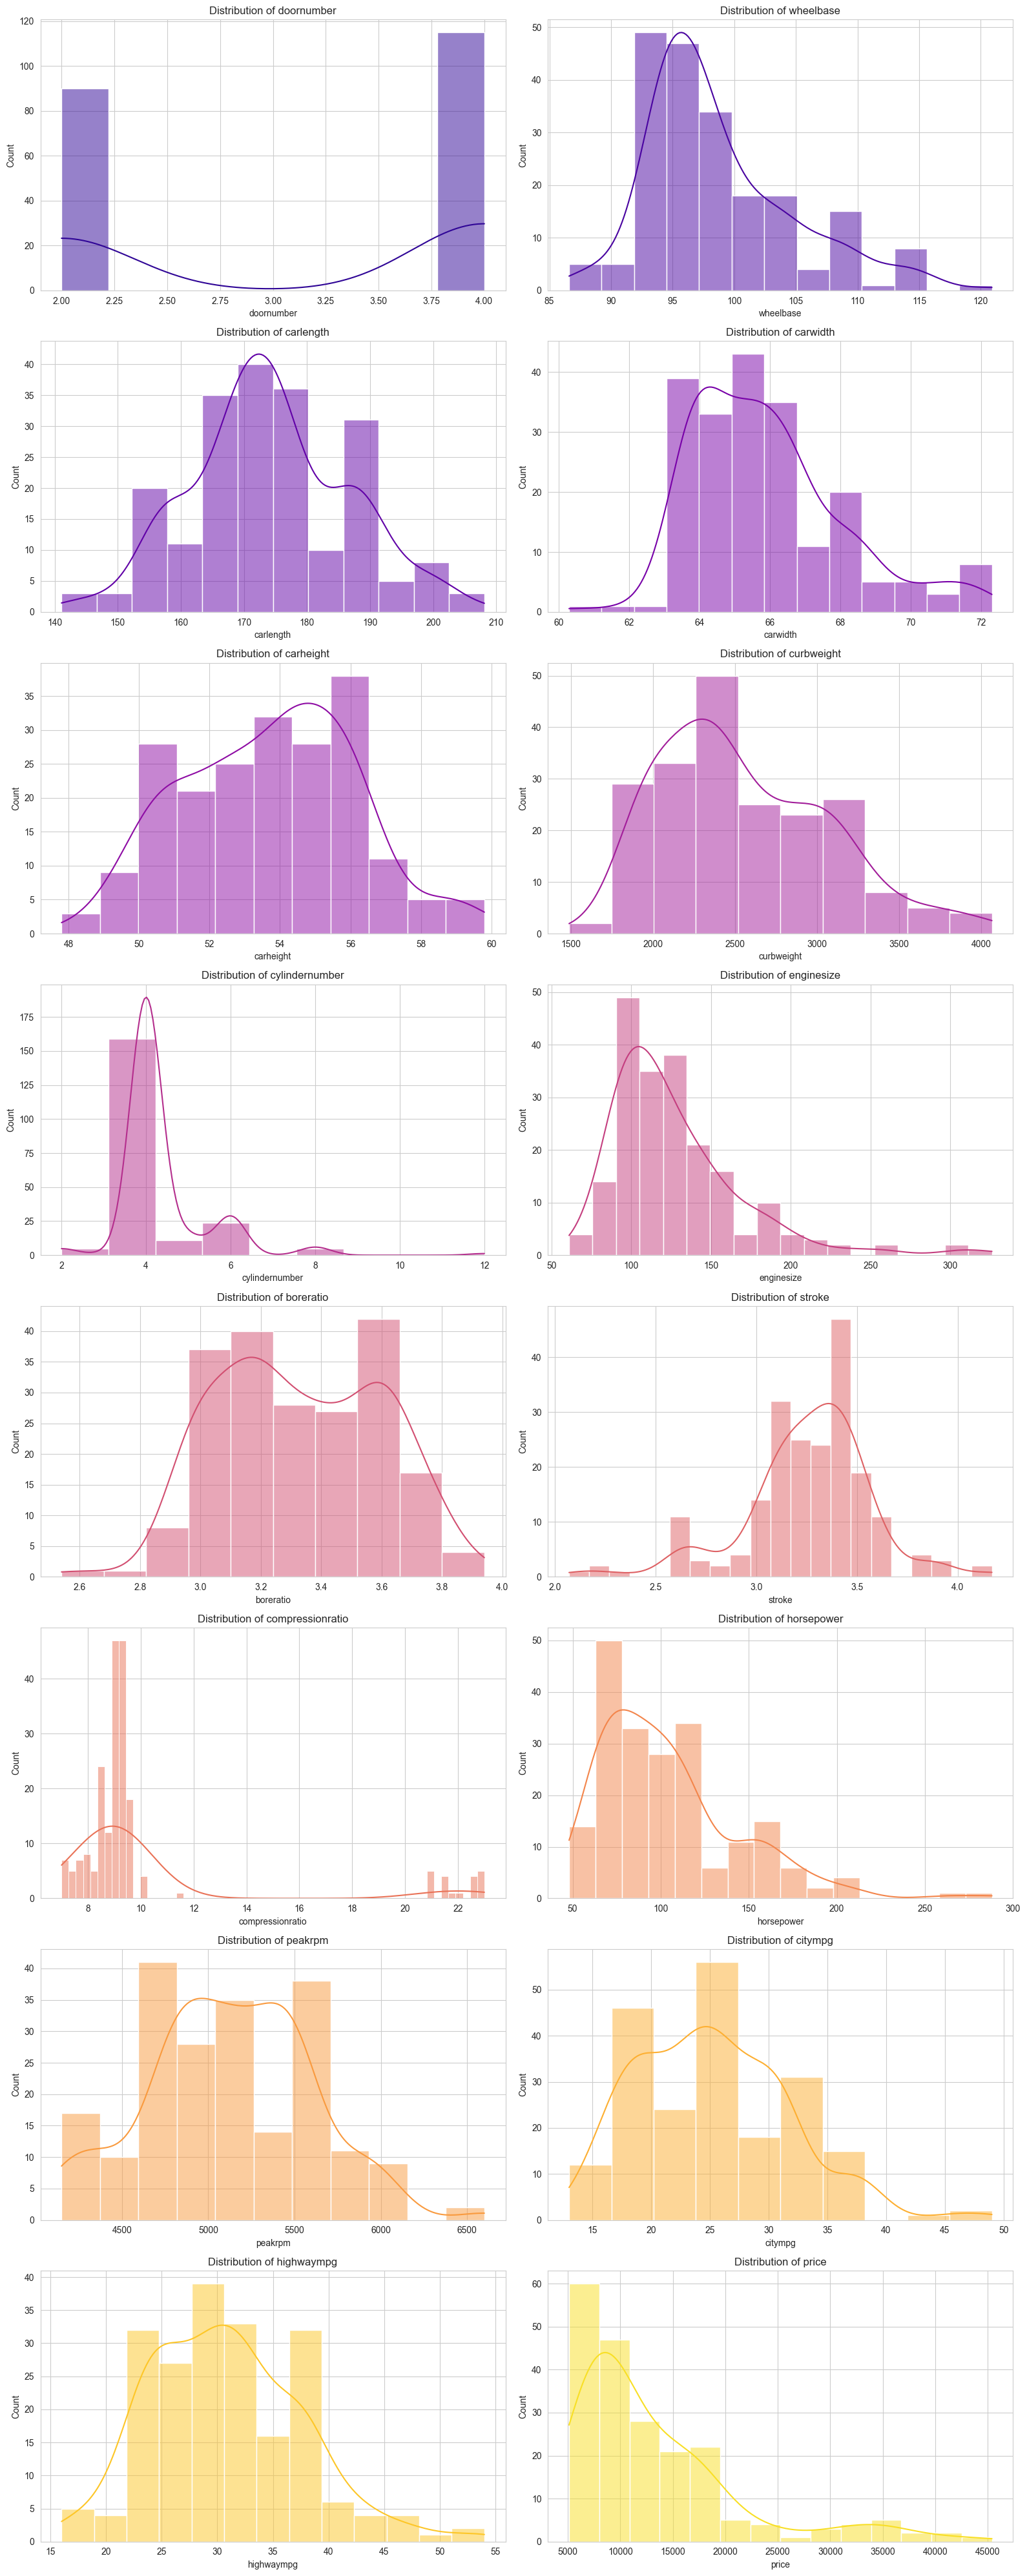

In [77]:
# Visualize Distributions of Numerical Features
# Automatically find numerical features
numerical_features = df_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

import math

colors = sns.color_palette("plasma", len(numerical_features))
n_features = len(numerical_features)
n_cols = 2
n_rows = math.ceil(n_features / n_cols)

sns.set_style('whitegrid')

plt.figure(figsize=(16, n_rows * 5))

for i, feature in enumerate(numerical_features):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.histplot(df_train[feature], kde=True, color=colors[i])
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

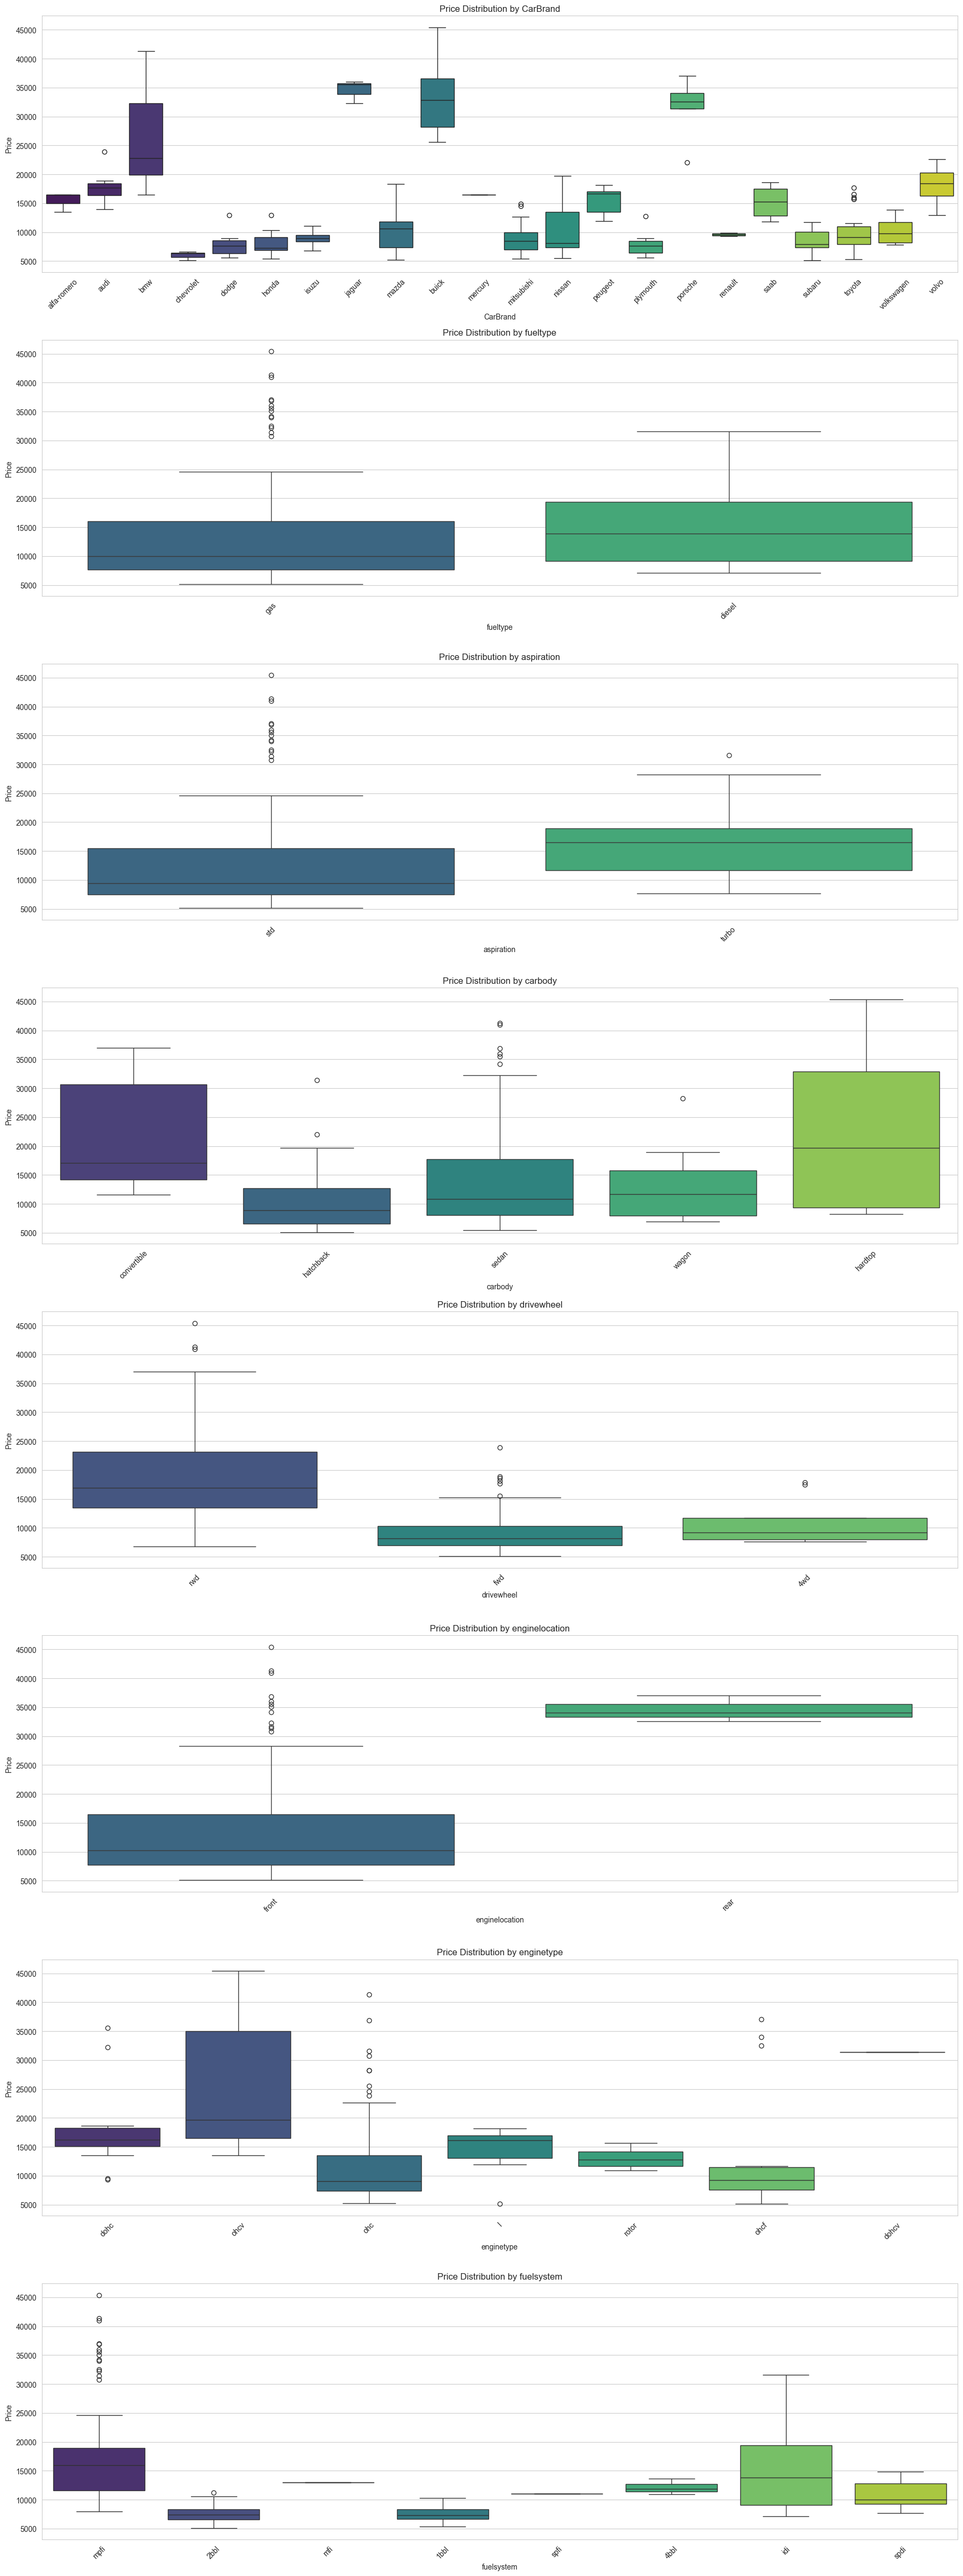

In [78]:
# Boxplots for Categorical Features
# Automatically find categorical features
categorical_features = df_train.select_dtypes(include='object').columns.tolist()

n_features = len(categorical_features)
plt.figure(figsize=(18, n_features * 6))

sns.set_style('whitegrid')

for i, feature in enumerate(categorical_features):
    plt.subplot(n_features, 1, i + 1)
    sns.boxplot(x=feature, y='price', data=df_train, palette='viridis')
    plt.title(f'Price Distribution by {feature}')
    plt.xlabel(feature)
    plt.ylabel('Price')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

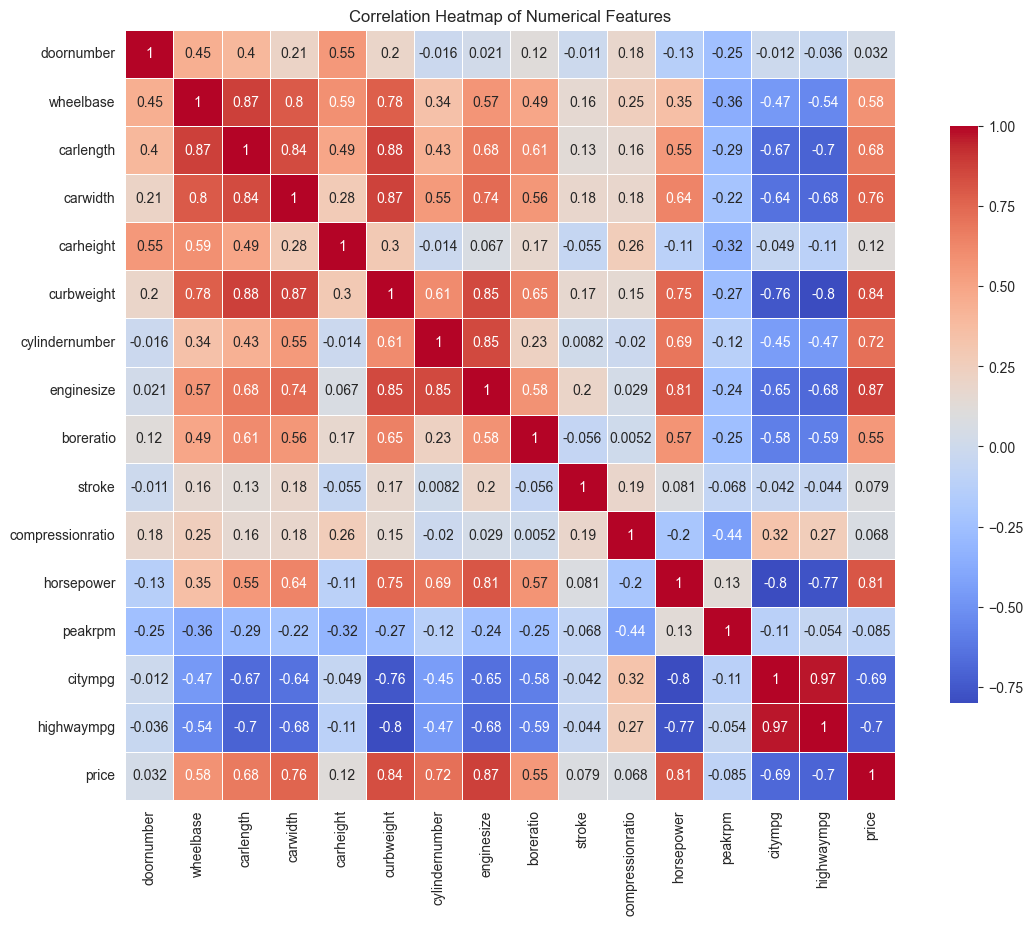

In [82]:
# Heatmap of Numerical Features Correlation
numeric_df = df_train.select_dtypes(include=['number'])

plt.figure(figsize=(14, 10), facecolor='white')
correlation_matrix = numeric_df.corr()

sns.heatmap(
    correlation_matrix,
    annot=True,            # Display correlation coefficients
    cmap='coolwarm',       # Color palette
    linewidths=0.5,        # Lines between cells
    linecolor='white',     # Line color between cells
    square=True,           # Square cells
    cbar_kws={"shrink": 0.75}  # Shrink colorbar
)

plt.title('Correlation Heatmap of Numerical Features')
plt.show()

#### 4. Підготовка остаточних даних

In [102]:
# Select features and apply log transformation
selected_features = ['horsepower', 'CarBrand', 'fueltype', 'carbody']
x = df_train[selected_features].copy()
y = np.log(df_train['price'])  # Log-transform the target

x['horsepower'] = np.log(x['horsepower'])

# One-Hot Encoding
x = pd.get_dummies(x, columns=['CarBrand', 'fueltype', 'carbody'], drop_first=True)

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=8418)

# Check the shape of the splits
X_train.shape, X_test.shape

((174, 27), (31, 27))

In [95]:
# Create a mapper for feature indexing
mapper = {i: value for i, value in enumerate(X_train.columns)}
mapper

{0: 'horsepower',
 1: 'CarBrand_audi',
 2: 'CarBrand_bmw',
 3: 'CarBrand_buick',
 4: 'CarBrand_chevrolet',
 5: 'CarBrand_dodge',
 6: 'CarBrand_honda',
 7: 'CarBrand_isuzu',
 8: 'CarBrand_jaguar',
 9: 'CarBrand_mazda',
 10: 'CarBrand_mercury',
 11: 'CarBrand_mitsubishi',
 12: 'CarBrand_nissan',
 13: 'CarBrand_peugeot',
 14: 'CarBrand_plymouth',
 15: 'CarBrand_porsche',
 16: 'CarBrand_renault',
 17: 'CarBrand_saab',
 18: 'CarBrand_subaru',
 19: 'CarBrand_toyota',
 20: 'CarBrand_volkswagen',
 21: 'CarBrand_volvo',
 22: 'fueltype_gas',
 23: 'carbody_hardtop',
 24: 'carbody_hatchback',
 25: 'carbody_sedan',
 26: 'carbody_wagon'}

In [96]:
# Preview the transformed dataset
X_train.head()

,horsepower,CarBrand_audi,CarBrand_bmw,CarBrand_buick,CarBrand_chevrolet,CarBrand_dodge,CarBrand_honda,CarBrand_isuzu,CarBrand_jaguar,CarBrand_mazda,...,CarBrand_saab,CarBrand_subaru,CarBrand_toyota,CarBrand_volkswagen,CarBrand_volvo,fueltype_gas,carbody_hardtop,carbody_hatchback,carbody_sedan,carbody_wagon
56,4.615121,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,True,False,True,False,False
171,4.753590,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,True,False,True,False,False
116,4.553877,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
89,4.234107,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,True,False
150,4.127134,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,True,False,True,False,False


In [97]:
# Check data info
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 174 entries, 56 to 136
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   horsepower           174 non-null    float64
 1   CarBrand_audi        174 non-null    bool   
 2   CarBrand_bmw         174 non-null    bool   
 3   CarBrand_buick       174 non-null    bool   
 4   CarBrand_chevrolet   174 non-null    bool   
 5   CarBrand_dodge       174 non-null    bool   
 6   CarBrand_honda       174 non-null    bool   
 7   CarBrand_isuzu       174 non-null    bool   
 8   CarBrand_jaguar      174 non-null    bool   
 9   CarBrand_mazda       174 non-null    bool   
 10  CarBrand_mercury     174 non-null    bool   
 11  CarBrand_mitsubishi  174 non-null    bool   
 12  CarBrand_nissan      174 non-null    bool   
 13  CarBrand_peugeot     174 non-null    bool   
 14  CarBrand_plymouth    174 non-null    bool   
 15  CarBrand_porsche     174 non-null    bool   

#### 5.1 Регресія Lasso

In [99]:
# Initialize Lasso Regression model
lasso = Lasso(alpha=0.001, random_state=8418)

# Train the Lasso model
lasso.fit(X_train, y_train)

# Make predictions
y_train_pred = lasso.predict(X_train)
y_test_pred = lasso.predict(X_test)

# Evaluate the model on the training set
print('Train R2 score:', metrics.r2_score(y_train, y_train_pred))
print('Train MAE:', metrics.mean_absolute_error(y_train, y_train_pred))
print("Train MAE on the original price scale:", np.exp(metrics.mean_absolute_error(y_train, y_train_pred)), "\n")

# Evaluate the model on the test set
print('Test R2 score:', metrics.r2_score(y_test, y_test_pred))
print('Test MAE:', metrics.mean_absolute_error(y_test, y_test_pred))
print("Test MAE on the original price scale:", np.exp(metrics.mean_absolute_error(y_test, y_test_pred)))

Train R2 score: 0.924010432790954
Train MAE: 0.1127199816193727
Train MAE on the original price scale: 1.1193184593190604 

Test R2 score: 0.9014266198450159
Test MAE: 0.1162961832600794
Test MAE on the original price scale: 1.1233285339737211


#### 5.2 Регресія Random Forest

In [101]:
# Initialize Random Forest Regressor
random_forest = RandomForestRegressor(
    n_estimators=100,      # Number of trees
    random_state=3,        # Reproducibility
    max_samples=0.5,       # 50% of the samples to build each tree
    max_features=0.75,     # 75% of the features for each split
    max_depth=15           # Limit the depth of each tree
)

# Train the Random Forest model
random_forest.fit(X_train, y_train)

# Make predictions
y_train_pred = random_forest.predict(X_train)
y_test_pred = random_forest.predict(X_test)

# Evaluate model on training data
print('Train R2 score:', metrics.r2_score(y_train, y_train_pred))
print('Train MAE:', metrics.mean_absolute_error(y_train, y_train_pred))
print("Train MAE on the original price scale:", np.exp(metrics.mean_absolute_error(y_train, y_train_pred)), "\n")

# Evaluate model on testing data
print('Test R2 score:', metrics.r2_score(y_test, y_test_pred))
print('Test MAE:', metrics.mean_absolute_error(y_test, y_test_pred))
print("Test MAE on the original price scale:", np.exp(metrics.mean_absolute_error(y_test, y_test_pred)))

Train R2 score: 0.9481345440580934
Train MAE: 0.09064388975247746
Train MAE on the original price scale: 1.0948790381816562 

Test R2 score: 0.8216958142784812
Test MAE: 0.14710864070505064
Test MAE on the original price scale: 1.1584798142572563


#### 5.3 Регресія Gradient Boosting

In [109]:
# Initialize the Gradient Boosting Regressor
gbr = GradientBoostingRegressor(
    n_estimators=100,      # Number of boosting stages
    learning_rate=0.1,     # How much each tree contributes
    max_depth=5,           # Maximum depth of individual trees
    random_state=8418
)

# Train the GBR model
gbr.fit(X_train, y_train)

# Make predictions
y_train_pred = gbr.predict(X_train)
y_test_pred = gbr.predict(X_test)

# Evaluate the model on the training set
print('Train R2 score:', metrics.r2_score(y_train, y_train_pred))
print('Train MAE:', metrics.mean_absolute_error(y_train, y_train_pred))
print("Train MAE on the original price scale:", np.exp(metrics.mean_absolute_error(y_train, y_train_pred)), "\n")

# Evaluate the model on the test set
print('Test R2 score:', metrics.r2_score(y_test, y_test_pred))
print('Test MAE:', metrics.mean_absolute_error(y_test, y_test_pred))
print("Test MAE on the original price scale:", np.exp(metrics.mean_absolute_error(y_test, y_test_pred)))

Train R2 score: 0.9791541457253876
Train MAE: 0.04988283825920274
Train MAE on the original price scale: 1.0511479348393737 

Test R2 score: 0.8325039438607005
Test MAE: 0.14709120386782645
Test MAE on the original price scale: 1.1584596142094206


##### Порівняння регресій

In [110]:
# Results based on previous outputs
results = pd.DataFrame({
    'Model': ['Lasso Regression', 'Random Forest', 'Gradient Boosting Regression'],

    'Train R2': [0.9240, 0.9481, 0.9791],
    'Test R2': [0.9014, 0.8217, 0.8325],

    'Train MAE (log)': [0.1127, 0.0906, 0.0499],
    'Test MAE (log)': [0.1163, 0.1471, 0.1471],

    'Test MAE (original scale)': [1.1233, 1.1585, 1.1585]
})

# Display comparison table
print("\nComparison of Lasso and Random Forest models:")
display(results)

# Find and print the best model based on Test R2
best_model = results.loc[results['Test R2'].idxmax()]
print(f"\nBest model based on Test R2: {best_model['Model']}")


Comparison of Lasso and Random Forest models:


,Model,Train R2,Test R2,Train MAE (log),Test MAE (log),Test MAE (original scale)
0,Lasso Regression,0.9240,0.9014,0.1127,0.1163,1.1233
1,Random Forest,0.9481,0.8217,0.0906,0.1471,1.1585
2,Gradient Boosting Regression,0.9791,0.8325,0.0499,0.1471,1.1585



Best model based on Test R2: Lasso Regression


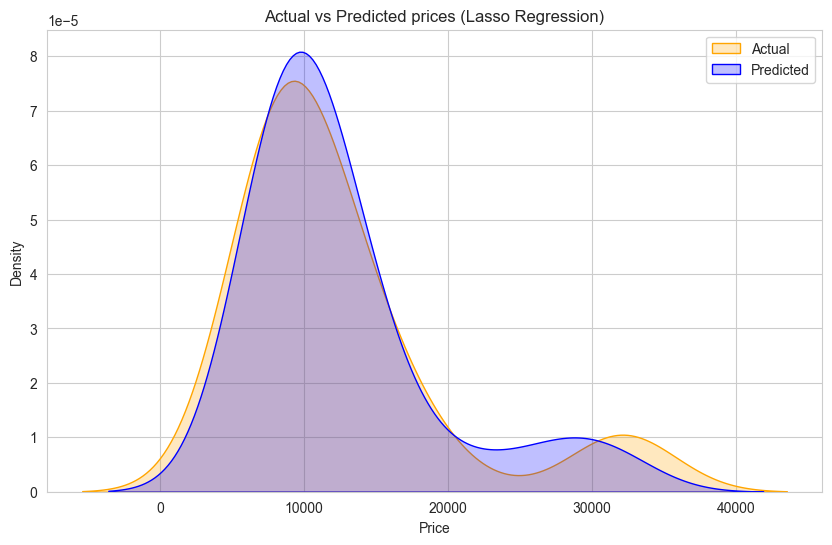

In [111]:
# Convert the log-transformed prices back to original scale
actual_prices = np.exp(y_test)
predicted_prices = np.exp(lasso.predict(X_test))

# Create a DataFrame to hold actual and predicted prices
comparison_df = pd.DataFrame({
    'Actual Price': actual_prices,
    'Predicted Price': predicted_prices
})

plt.figure(figsize=(10, 6))

# KDE plot for actual prices
sns.kdeplot(comparison_df['Actual Price'], color='orange', label='Actual', fill=True)
# KDE plot for predicted prices
sns.kdeplot(comparison_df['Predicted Price'], color='blue', label='Predicted', fill=True)

sns.set_style('whitegrid')

# Plot settings
plt.xlabel('Price')
plt.ylabel('Density')
plt.title('Actual vs Predicted prices (Lasso Regression)')
plt.legend()
plt.show()

> **Висновок**: у цій роботі проведено аналіз даних та побудовано моделі для прогнозування ціни автомобіля на основі таких характеристик, як потужність двигуна (horsepower), бренд автомобіля, тип палива та тип кузова. На етапі підготовки даних виконано очищення, приведення ознак до зручного формату, застосовано логарифмування для вирівнювання розподілу та проведено кодування категоріальних ознак. Після підготовки даних були побудовані та протестовані три моделі: Lasso Regression, Random Forest Regression та Gradient Boosting Regression. За результатами порівняння найкращу якість показала модель Lasso Regression, яка має найвищий показник R² на тестових даних і продемонструвала стабільні результати без значного перенавчання. Моделі Random Forest та Gradient Boosting мали кращі результати на тренувальних даних, однак на тестових даних показали гіршу узагальнюючу здатність, що свідчить про певний рівень перенавчання. У підсумку можна сказати, що використовуючи лише кілька базових характеристик автомобіля, можна побудувати доволі ефективну модель прогнозування ціни.